In [0]:
from keras.layers import Conv2D,Dense,Flatten,GlobalAveragePooling2D,MaxPool2D,BatchNormalization,Activation,Input,Add
import keras.backend as K
import numpy as np
from keras.optimizers import Adam,SGD
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import to_categorical,plot_model
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [3]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
print(x_train.shape,x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
n_classes=len(class_names)

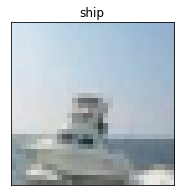

In [6]:

plt.figure(figsize=(3,3))
plt.imshow(x_train[100])
plt.title(class_names[y_train[100][0]])
plt.xticks([])
plt.yticks([])
plt.show()


In [0]:
BS=128
N_EPOCHS=50


In [0]:
train_features = x_train.astype('float')/255.
test_features= x_test.astype('float')/255.

In [0]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [0]:
trn_mean = np.mean(train_features,axis=0)
train_features = train_features-trn_mean
test_features = test_features-trn_mean

In [0]:
def basic_conv(inputs,filters=32,kernel_size=3,padding='same',strides=1,bn=True,activation='relu',conv_first=True):
  conv=Conv2D(filters,kernel_size=kernel_size,strides=strides,padding=padding,kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))
  if conv_first:
    x=conv(inputs)
    if bn:
      x=BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if bn:
      x=BatchNormalization()(inputs)
    if activation is not None:
      x=Activation(activation)(x)
    x=conv(x)
  return x

In [0]:
def build_model():
  # defining input layer
  inputs=Input(shape=(None,None,3))
  # defining the first convolutional layer. After this layer, we have 16 channels
  x = basic_conv(inputs,filters=16)
  # defining intial channels to be 16
  nfilters=16
  # create blocks of 4 stacks of 2 res layers. Each res layer has 2 conv blocks
  for i in range(4):
    # for first stack we don't need to downsample
    if i==0:
      strides=1
    else:
      strides=2
    for j in range(2):
      # downsample only when stack number > 0
      if j==0:
        y=basic_conv(x,filters=nfilters,strides=strides)
      else:
        y=basic_conv(x,filters=nfilters)
      y=basic_conv(y,filters=nfilters,activation=None)
      if i>0 and j==0:
        x=basic_conv(x,filters=nfilters,kernel_size=1,strides=strides,activation=None,bn=False)
      x = Add()([x,y])
      x=Activation('relu')(x)
    nfilters*=2
  x=GlobalAveragePooling2D()(x)
  outputs=Dense(n_classes,activation='softmax',kernel_initializer='he_normal')(x)
  return Model(inputs,outputs)

In [14]:
model = build_model()

In [66]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

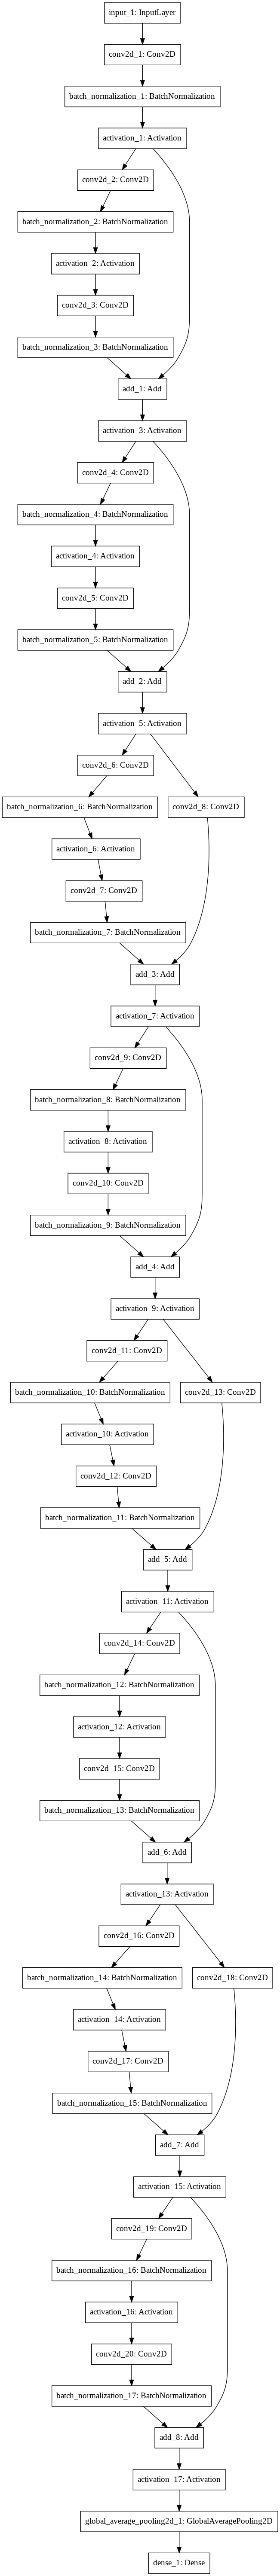

In [65]:
plot_model(model,to_file='model.png')

In [15]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=0.1,width_shift_range=0.1,height_shift_range=0.1)

In [18]:
model.fit_generator(datagen.flow(train_features,train_labels,batch_size=64),samples_per_epoch=train_features.shape[0],
                    validation_data=(test_features,test_labels),epochs=N_EPOCHS,verbose=1,callbacks=[lr_reducer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., epochs=50, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=781)`
  




Epoch 1/50
781/781 [==============================] - 38s 49ms/step - loss: 1.7014 - acc: 0.4651 - val_loss: 1.4889 - val_acc: 0.5436
Epoch 2/50
781/781 [==============================] - 32s 41ms/step - loss: 1.3098 - acc: 0.6105 - val_loss: 1.2239 - val_acc: 0.6481
Epoch 3/50
781/781 [==============================] - 32s 41ms/step - loss: 1.1152 - acc: 0.6837 - val_loss: 1.1794 - val_acc: 0.6772
Epoch 4/50
781/781 [==============================] - 32s 41ms/step - loss: 0.9922 - acc: 0.7279 - val_loss: 1.1264 - val_acc: 0.6914
Epoch 5/50
781/781 [==============================] - 32s 41ms/step - loss: 0.9167 - acc: 0.7549 - val_loss: 1.4435 - val_acc: 0.6360
Epoch 6/50
781/781 [==============================] - 32s 41ms/step - loss: 0.8554 - acc: 0.7794 - val_loss: 1.0306 - val_acc: 0.7262
Epoch 7/50
781/781 [==============================] - 32s 41ms/step - loss: 0.8240 - acc: 0.7876 - val_loss: 0.9669 - val_acc: 0.7387
Epoch 8/50
781/781 [==============================] - 32s 41

### GRADCAM

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import keras.backend as K
from skimage import io


In [0]:
urls=['https://images.pexels.com/photos/434090/pexels-photo-434090.jpeg?cs=srgb&dl=adorable-animal-breed-434090.jpg&fm=jpg','https://images.pexels.com/photos/733416/pexels-photo-733416.jpeg?cs=srgb&dl=animal-canine-dog-733416.jpg&fm=jpg',
      'https://images.pexels.com/photos/170811/pexels-photo-170811.jpeg?cs=srgb&dl=blue-bmw-sedan-near-green-lawn-grass-170811.jpg&fm=jpg','https://images.pexels.com/photos/119435/pexels-photo-119435.jpeg?cs=srgb&dl=automobile-automotive-car-119435.jpg&fm=jpg',
      'https://images.pexels.com/photos/104827/cat-pet-animal-domestic-104827.jpeg?cs=srgb&dl=animal-animal-photography-cat-104827.jpg&fm=jpg','https://images.pexels.com/photos/1302290/pexels-photo-1302290.jpeg?cs=srgb&dl=shallow-focus-photography-of-white-cat-1302290.jpg&fm=jpg',
      'https://images.pexels.com/photos/1027752/pexels-photo-1027752.jpeg?cs=srgb&dl=animal-animal-photography-blur-1027752.jpg&fm=jpg','https://images.pexels.com/photos/1543834/pexels-photo-1543834.jpeg?cs=srgb&dl=selective-focus-photography-of-brown-horse-1543834.jpg&fm=jpg',
      'https://images.pexels.com/photos/68737/cruise-ship-holidays-cruise-vacation-68737.jpeg?cs=srgb&dl=ocean-sea-ship-68737.jpg&fm=jpg','https://images.pexels.com/photos/69122/ferry-boat-ferry-ship-boat-69122.jpeg?cs=srgb&dl=carnival-victory-cruise-cruise-liner-69122.jpg&fm=jpg']

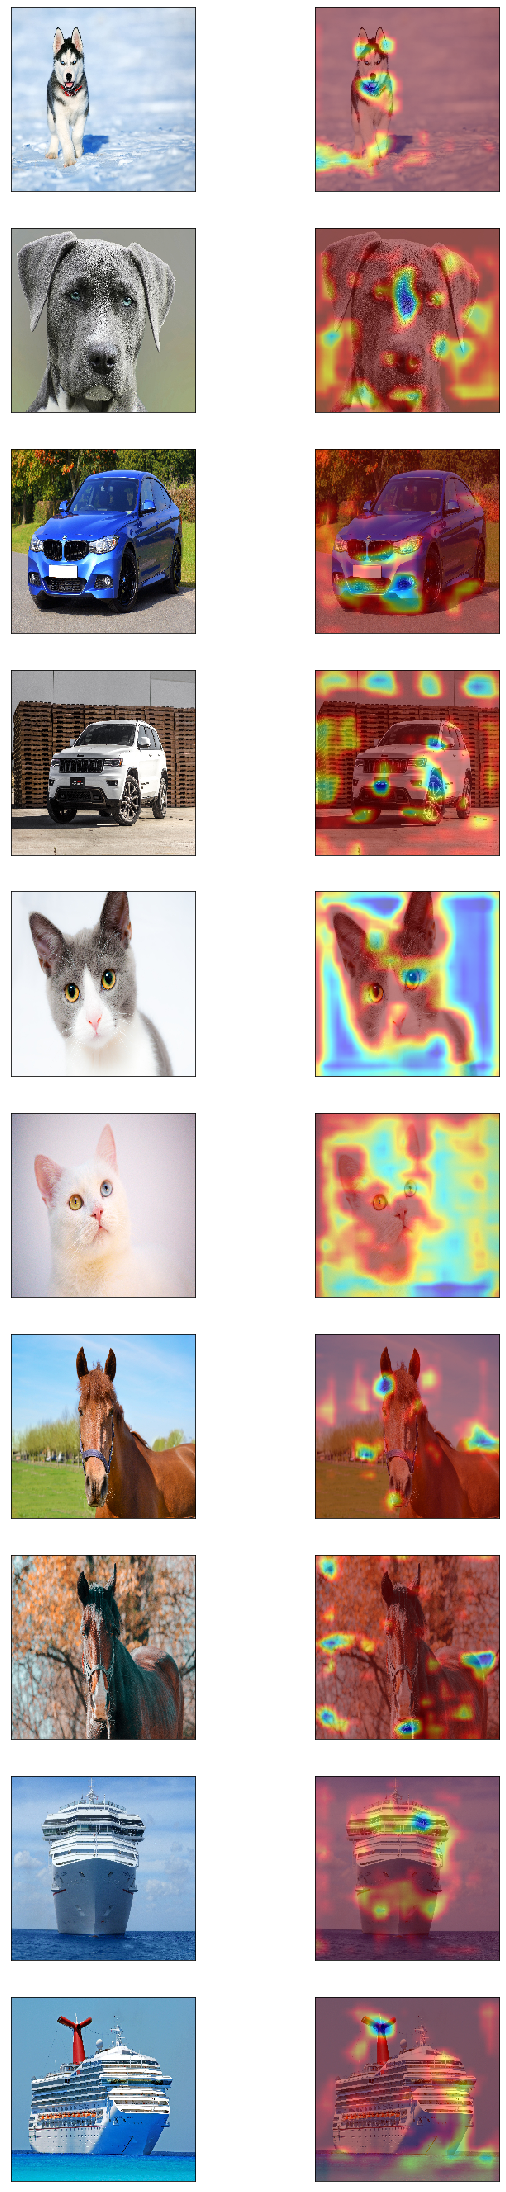

In [64]:
fig,axs =plt.subplots(10,2,figsize=(10,40))
for i,u in enumerate(urls):
  response = requests.get(u)
  img = np.array(Image.open(BytesIO(response.content)))
  img = cv2.resize(img,(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  x=x/255.
  preds = model.predict(x)
  class_preds = np.argmax(preds[0])
  class_output = model.output[:,class_preds]
  conv_layer = model.get_layer('conv2d_20')
  grads = K.gradients(class_output,conv_layer.output)[0]
  pooled_grads = K.mean(grads,(0,1,2))
  iterate = K.function([model.input],[pooled_grads,conv_layer.output[0]])
  pooled_grads_value,conv_layer_value = iterate([x])
  for j in range(128):
    conv_layer_value[:,:,j]*=pooled_grads_value[j]
  heatmap = np.mean(conv_layer_value,axis=-1)
  heatmap=np.maximum(heatmap,0)
  heatmap/=np.max(heatmap)
  heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)  
  axs[i,0].imshow(img)
  axs[i,0].set_xticks([])
  axs[i,0].set_yticks([])
  axs[i,1].imshow(superimposed_img)
  axs[i,1].set_xticks([])
  axs[i,1].set_yticks([])
#plt.show()